In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import rsciio.digitalmicrograph as dm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import time
from scipy import signal
from concurrent.futures import ThreadPoolExecutor, as_completed

In [68]:
class NNTrainer:
    def __init__(self, x_data, y_data):
        self.X = x_data.clone() # input data [n_E, 2]
        self.y = y_data.clone() # output data [n_E, n_spectrum]
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = EELSBackgroundNet().to(self.device)

        self.min_y = torch.min(self.y).item()
        self.max_y = torch.max(self.y).item()
        self.y = (self.y - self.min_y) / (self.max_y - self.min_y) # Normalize y to [0, 1]

        self.min_x1 = torch.min(self.X[:, 0]).item()
        self.max_x1 = torch.max(self.X[:, 0]).item()
        self.min_x2 = torch.min(self.X[:, 1]).item()
        self.max_x2 = torch.max(self.X[:, 1]).item()

        self.X[:, 0] = (self.X[:, 0] - self.min_x1) / (self.max_x1 - self.min_x1) # Normalize energy to [0, 1]
        self.X[:, 1] = (self.X[:, 1] - self.min_x2) / (self.max_x2 - self.min_x2) # Normalize total integrated intensity to [0, 1]

    @staticmethod
    def loss_function(y_true, y_pred):
        mse_loss = nn.MSELoss()(y_pred, y_true)
        return mse_loss


    def train(self, epochs=20, lr=0.001):
        """Training method for the neural networks ."""
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        # DataLoader with pin_memory for faster transfer (if using GPU)
        dataset = TensorDataset(self.X, self.y)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True, pin_memory=True 
                                if self.device.type == "cuda" else False)

        for epoch in range(epochs):
            self.model.train()
            epoch_loss = 0.0
            start_time = time.time()

            for inputs, targets in dataloader:
                inputs = inputs.to(self.device, non_blocking=True)
                targets = targets.to(self.device, non_blocking=True)

                optimizer.zero_grad()
                outputs = self.model(inputs)

                loss = self.loss_function(outputs.squeeze(), targets)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item() * inputs.size(0)
            print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f} - Time: {time.time() - start_time:.2f}s")

    def evaluate_model(self, x_eval):
        # Evaluate the model on the training data
        x_eval_reshaped = x_eval.reshape(-1,2).clone()
        x_eval_reshaped[:,0] = (x_eval_reshaped[:,0] - self.min_x1) / (self.max_x1 - self.min_x1)

        x_eval_reshaped[:,1] = (x_eval_reshaped[:,1] - self.min_x2) / (self.max_x2 - self.min_x2)
        x_eval_reshaped = x_eval_reshaped.to(self.device)

        with torch.no_grad():
            self.model.eval()
            outputs_normalized = self.model(x_eval_reshaped)
            outputs_normalized = outputs_normalized * (self.max_y - self.min_y) + self.min_y
            outputs = outputs_normalized.reshape(x_eval.shape[0], -1)
        return outputs
        


class EELSBackgroundNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)


In [60]:
class NNparameterization:

    def __init__(self):
        self.spatial_axis = None
        self.energy_axis = None
        self.intensity_data = None

        self.clusters = None
        self.clustered_spectra_mean = None
        self.clustered_spectra_std = None

        self.total_integrated_intensity = None

        self.y = None
        self.X_mc = None

        self.X_eval = None

        self.background = None
    def read_dm3(self, path):
        '''Read EELS data from a DM3 file
        
        Parameters
        ----------
        path : str
            Path to the DM3 file
        '''
        raw_data = dm.file_reader(path)
        # Extracting the core loss data
        self.intensity_data = raw_data[0]['data'][:,:]

        # core_loss_data[core_loss_data>4000] = 0

        # Extracting the energy loss axis and spatial axis
        energy_loss_md = raw_data[0]['axes'][1]
        begin, dispersion, size = energy_loss_md['offset'], energy_loss_md['scale'], energy_loss_md['size']
        self.energy_axis = np.linspace(begin, begin + dispersion * (size - 1), size)

        spatial_md = raw_data[0]['axes'][0]
        begin, step, size = spatial_md['offset'], spatial_md['scale'], spatial_md['size']
        self.spatial_axis = np.linspace(begin, begin + step * (size - 1), size)
    
    def align_data(self, reference_spectrum_index = 0):
        '''
        Aligns the core loss data by cross-correlating the data with the reference spectrum
        '''
        shifts = []
        reference_spectrum = self.intensity_data[reference_spectrum_index]
        for i, x in enumerate(self.intensity_data):
            cross_correlate = signal.correlate(x, reference_spectrum, mode='full')
            shift = len(x) - np.argmax(cross_correlate)
            self.intensity_data[i] = np.roll(x, shift)
            shifts.append(shift)

        #window data such that all spectra starts/ends at the same energy loss
        self.window_data(lower = self.energy_axis[max(shifts)], 
                         higher = self.energy_axis[min(shifts)] if min(shifts)<0 else  1e6)
                
    def window_data(self, lower=0, higher=1e6):
        '''
        Windows the core loss data to a specific energy loss range
        '''
        window = (self.energy_axis<higher)&(self.energy_axis>lower)
        self.intensity_data = self.intensity_data[:,window]
        self.energy_axis = self.energy_axis[window]

    def plot_spectra(self, spectra_indices=None):
        '''
        Plots the core loss data for the specified spectra indices
        '''
        if spectra_indices is None:
            spectra_indices = range(self.intensity_data.shape[0])
        plt.figure(figsize=(10, 6))
        for i in spectra_indices:
            plt.plot(self.energy_axis, self.intensity_data[i], label=f'Spectrum {i}')
        plt.xlabel('Energy Loss (eV)')
        plt.ylabel('Intensity (a.u.)')
        plt.title('Core Loss Spectra')
        plt.legend()
        plt.show()

    def calculate_integrated_intensity(self):
        self.total_integrated_intensity = np.sum(self.intensity_data, axis=1) # shape [n_spectrum]

    def cluster_data(self, n_clusters):
        kmeans = KMeans(n_clusters=n_clusters)
        clusters = kmeans.fit_predict(self.total_integrated_intensity.reshape(-1, 1))
        self.clustered_spectra_mean = np.zeros((len(self.energy_axis), n_clusters))
        self.clustered_spectra_std = np.zeros((len(self.energy_axis), n_clusters))
        self.clustered_spectra_centers = kmeans.cluster_centers_
        for i in range(n_clusters):
            self.clustered_spectra_mean[:, i] = np.mean(self.intensity_data[:][clusters == i], axis=0)
            self.clustered_spectra_std[:, i] = np.std(self.intensity_data[:][clusters == i], axis=0) 

    def prepare_X_mc_data(self):
        
        num_energy_loss, num_clusters = self.clustered_spectra_mean.shape

        # normalized_energy_axis = np.linspace(0, 1, num_energy_loss) # shape [n_E]
        energy_axis_expanded = torch.Tensor(self.energy_axis).unsqueeze(0).expand(num_clusters, -1) # shape [num_clusters, n_E]

        clustered_spectra_centers = torch.Tensor(self.clustered_spectra_centers).squeeze()  # Remove extra dimensions if any
        clustered_spectra_centers_expanded = torch.log(clustered_spectra_centers.unsqueeze(1).expand(-1, num_energy_loss))  # shape [num_clusters, n_E]

        X_mc = torch.stack([
            energy_axis_expanded, 
            clustered_spectra_centers_expanded
        ], dim=2)

        self.X_mc = X_mc.reshape(-1, 2) # shape [n_cluster*n_E, 2]

    def prepare_X_eval_data(self):
        num_spectra, num_energy_loss = self.intensity_data.shape

        # energy_axis = np.linspace(0, 1, num_energy_loss) # shape [n_E]
        energy_axis_expanded = torch.Tensor(self.energy_axis).unsqueeze(0).expand(num_spectra, -1)
        total_integrated_intensity_expanded = torch.log(torch.Tensor(self.total_integrated_intensity).unsqueeze(1).expand(-1, num_energy_loss))
        X_eval = torch.stack([
            energy_axis_expanded, 
            total_integrated_intensity_expanded
        ], dim=2)

        self.X_eval = X_eval

    def train_MC_replica_consecutive(self, n_mc_replicas):
        self.background_mean = np.zeros_like(self.intensity_data)
        self.background_std = np.zeros_like(self.intensity_data)
        self.background = np.zeros((n_mc_replicas, self.intensity_data.shape[0], self.intensity_data.shape[1])) # shape [n_mc_replicas, n_spectrum, n_E]
        for i in range(n_mc_replicas):
            mc_replica = np.log(np.random.normal(self.clustered_spectra_mean,
                                          self.clustered_spectra_std )) # shape [n_E, n_clusters]
            plt.plot(mc_replica, color = ['red', 'blue'][i%2], alpha = 0.5)
            if np.any(mc_replica <= 0):
                print("Warning: log input has non-positive values")
            y = torch.Tensor(mc_replica.T).reshape(-1) # shape [n_clusters*n_E]
            NN_object = NNTrainer(self.X_mc, y)
            NN_object.train()

            self.background[i] = np.exp(NN_object.evaluate_model(self.X_eval).squeeze(-1)) #shape [n_spectrum, n_E]

    def train_MC_replica_parallel(self, n_mc_replicas):
        self.background_mean = np.zeros_like(self.intensity_data)
        self.background_std = np.zeros_like(self.intensity_data)
        self.background = np.zeros((n_mc_replicas, self.intensity_data.shape[0], self.intensity_data.shape[1]))

        def run(i):
            mc_sample = np.random.normal(self.clustered_spectra_mean, self.clustered_spectra_std)
            if np.any(mc_sample <= 0):
                print(f"Warning in replica {i}: non-positive values")
            mc_replica = np.log(mc_sample)
            y = torch.tensor(mc_replica.T.astype(np.float32)).reshape(-1)

            NN_object = NNTrainer(self.X_mc, y)
            NN_object.train()
            background_i = np.exp(NN_object.evaluate_model(self.X_eval).squeeze(-1))
            return i, background_i

        with ThreadPoolExecutor(max_workers=10) as executor:  # Adjust worker count as needed
            futures = [executor.submit(run, i) for i in range(n_mc_replicas)]

            for future in as_completed(futures):
                i, result = future.result()
                self.background[i] = result


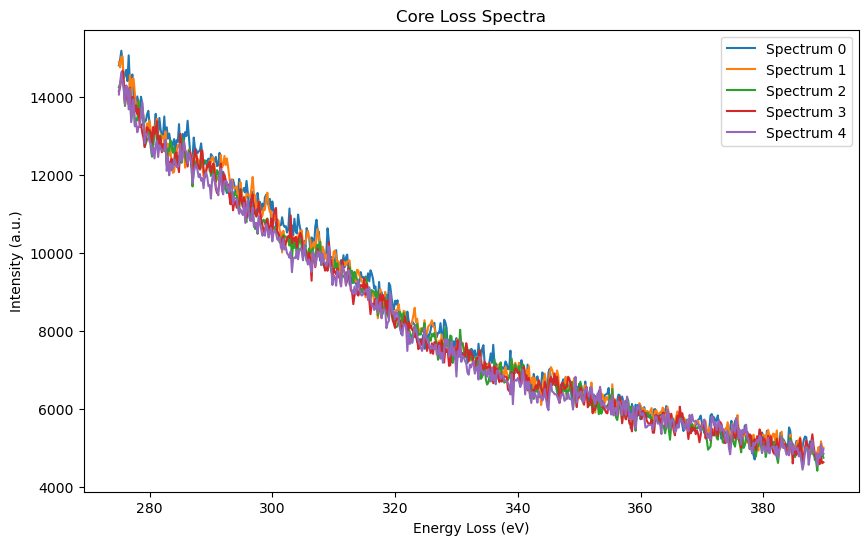

c:\Users\bartv\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Epoch [1/20] - Loss: 73.9087 - Time: 1.49s
Epoch [1/20] - Loss: 95.6054 - Time: 1.44s
Epoch [1/20] - Loss: 63.5593 - Time: 1.48s
Epoch [1/20] - Loss: 173.5087 - Time: 1.50s
Epoch [1/20] - Loss: 51.2839 - Time: 1.44s
Epoch [1/20] - Loss: 111.1559 - Time: 1.50s
Epoch [1/20] - Loss: 79.1455 - Time: 1.46s
Epoch [1/20] - Loss: 161.5218 - Time: 1.46s
Epoch [1/20] - Loss: 101.6767 - Time: 1.45s
Epoch [1/20] - Loss: 73.4076 - Time: 1.45s
Epoch [2/20] - Loss: 13.7185 - Time: 1.32s
Epoch [2/20] - Loss: 11.4545 - Time: 1.43s
Epoch [2/20] - Loss: 11.8053 - Time: 1.46s
Epoch [2/20] - Loss: 15.2186 - Time: 1.47s
Epoch [2/20] - Loss: 13.5017 - Time: 1.47s
Epoch [2/20] - Loss: 12.3585 - Time: 1.48s
Epoch [2/20] - Loss: 22.4195 - Time: 1.48s
Epoch [2/20] - Loss: 15.4689 - Time: 1.48s
Epoch [2/20] - Loss: 15.7737 - Time: 1.48s
Epoch [2/20] - Loss: 15.6030 - Time: 1.50s
Epoch [3/20] - Loss: 11.5523 - Time: 1.45s
Epoch [3/20] - Loss: 9.6501 - Time: 1.49s
Epoch [3/20] - Loss: 10.3429 - Time: 1.46s
Epoch [3

C:\Users\bartv\AppData\Local\Temp\ipykernel_18216\2867104394.py:155: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  background_i = np.exp(NN_object.evaluate_model(self.X_eval).squeeze(-1))
C:\Users\bartv\AppData\Local\Temp\ipykernel_18216\2867104394.py:163: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  self.background[i] = result


Epoch [20/20] - Loss: 6.4440 - Time: 1.28s
Epoch [20/20] - Loss: 7.0095 - Time: 1.26s
Epoch [20/20] - Loss: 5.2563 - Time: 1.30s
Epoch [20/20] - Loss: 5.2526 - Time: 1.29s


In [69]:
path_to_data = "../Data/008_core_loss_line_020evpx_1mm.dm3"
objectNN = NNparameterization()
objectNN.read_dm3(path_to_data)
objectNN.align_data()
objectNN.window_data(lower=275, higher=390)
objectNN.plot_spectra(spectra_indices=[0, 1, 2, 3, 4])
objectNN.calculate_integrated_intensity()
objectNN.cluster_data(n_clusters=4)
objectNN.prepare_X_mc_data()
objectNN.prepare_X_eval_data()
objectNN.train_MC_replica_parallel(n_mc_replicas=10)

(10, 84, 575)


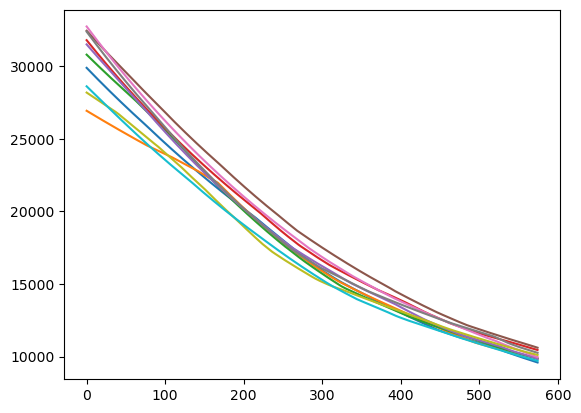

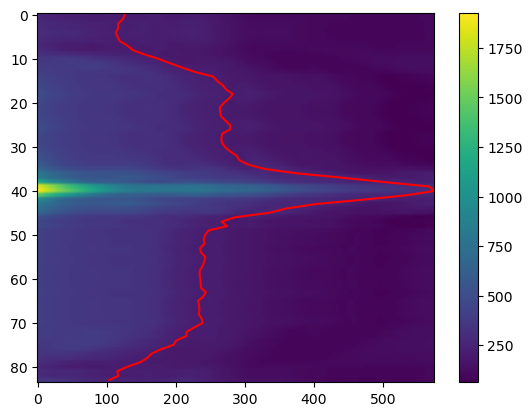

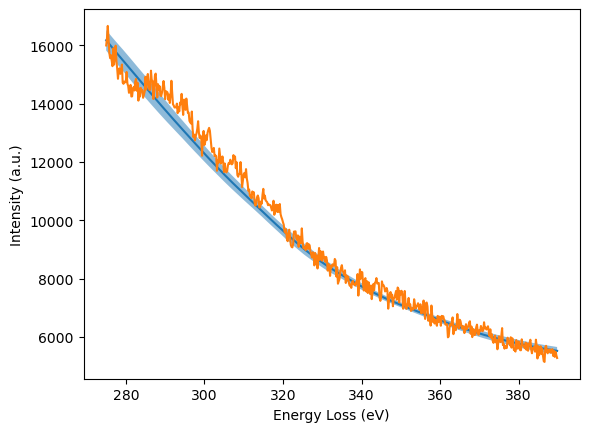

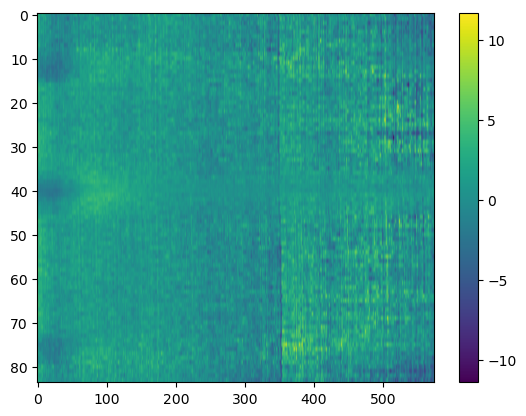

In [94]:
objectNN.background.shape
print(objectNN.background.shape)
bgmean = np.mean(objectNN.background, axis=0)
bgstd = np.std(objectNN.background, axis=0)

plt.plot(objectNN.background[:,40,:].T)
# plt.plot(objectNN.intensity_data.T, alpha=0.5)
# plt.colorbar()
# plt.plot(objectNN.background[0])
# print(objectNN.background[1]-objectNN.background[0])
# plt.imshow(bgmean, aspect='auto', cmap='viridis')
# plt.colorbar()
plt.show()
tii = objectNN.total_integrated_intensity
frac = 0.7
plt.plot((tii-frac*min(tii))/(max(tii)-min(tii)*frac)*len(objectNN.energy_axis), range(len(objectNN.spatial_axis)), color='red')
plt.imshow(bgstd, aspect='auto', cmap='viridis')
plt.colorbar()
plt.show()


show_spectrum = 10
plt.plot(objectNN.energy_axis, bgmean[show_spectrum], label='Mean Background')
plt.fill_between(objectNN.energy_axis, bgmean[show_spectrum]-bgstd[show_spectrum], bgmean[show_spectrum]+bgstd[show_spectrum], alpha=0.5, label='1 Std Dev')
plt.plot(objectNN.energy_axis, objectNN.intensity_data[show_spectrum], label='Spectrum 40')
plt.xlabel('Energy Loss (eV)')
plt.ylabel('Intensity (a.u.)')
plt.show()

plt.imshow((objectNN.intensity_data-bgmean)/bgstd, aspect='auto', cmap='viridis')
plt.colorbar()
plt.show()

In [7]:
path_to_data = "../data/008_core_loss_line_020evpx_1mm.dm3"

raw_data = dm.file_reader(path_to_data)

# Extracting the core loss data
core_loss_data = raw_data[0]['data'][:500,:]
# core_loss_data[core_loss_data>4000] = 0

# Extracting the energy loss axis and spatial axis
energy_loss_md = raw_data[0]['axes'][1]
begin, dispersion, size = energy_loss_md['offset'], energy_loss_md['scale'], energy_loss_md['size']
energy_loss_axis = np.linspace(begin, begin + dispersion * (size - 1), size)

spatial_md = raw_data[0]['axes'][0]
begin, step, size = spatial_md['offset'], spatial_md['scale'], spatial_md['size']
spatial_axis = np.linspace(begin, begin + step * (size - 1), size)
print


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

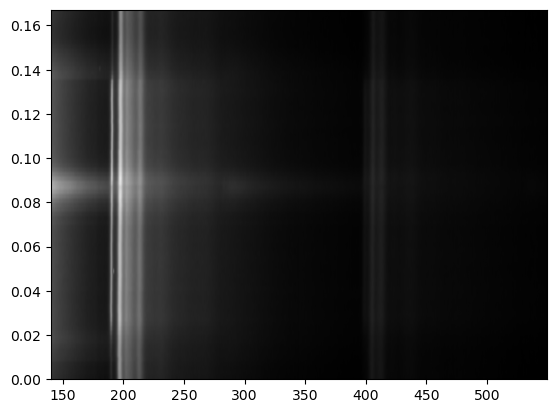

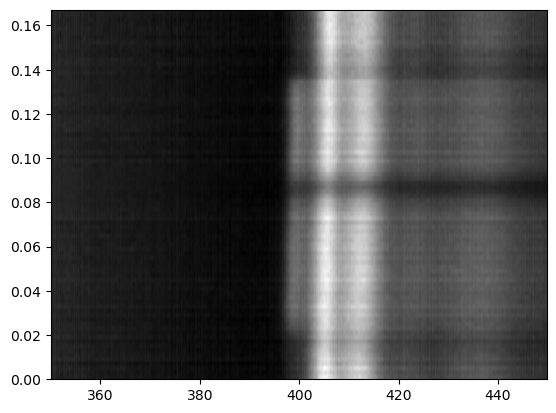

In [8]:
plt.imshow(core_loss_data, cmap='gray', aspect='auto', extent=
        [energy_loss_axis[0], energy_loss_axis[-1], spatial_axis[0], spatial_axis[-1]])
plt.show()
# core_loss_data_trimmed = np.concatenate((core_loss_data[:14,1500:], core_loss_data[75:,1500:]))
window = (energy_loss_axis > 350) & (energy_loss_axis < 450)
core_loss_data_trimmed = core_loss_data[:, window]

core_loss_data_trimmed /= core_loss_data_trimmed[:,0].reshape(-1, 1)
energy_loss_axis_trimmed = energy_loss_axis[window]
plt.imshow(core_loss_data_trimmed, cmap='gray', aspect='auto', extent=
        [energy_loss_axis_trimmed[0], energy_loss_axis_trimmed[-1], spatial_axis[0], spatial_axis[-1]])
plt.show()

In [9]:
intensities = torch.tensor(core_loss_data_trimmed, dtype=torch.float32)  
energy_axis = torch.tensor(energy_loss_axis_trimmed, dtype=torch.float32)
spatial_axis = torch.tensor(spatial_axis, dtype=torch.float32)

exclude_min = 0
exclude_max = 0
mask = (energy_axis < exclude_min) | (energy_axis > exclude_max)

filtered_energy_axis = energy_axis[mask]
filtered_intensities = intensities[:, mask]


# include_spectra_mask = ((spatial_axis < 0.13) & (spatial_axis > 0.09)) | ((spatial_axis < 0.08) & (spatial_axis > 0.03))

# filtered_intensities = filtered_intensities[include_spectra_mask,:]
# filtered_spatial_axis = spatial_axis[include_spectra_mask]

num_spectra, num_energy_loss = filtered_intensities.shape

log_total_intensity = torch.log(intensities.sum(dim=1, keepdim=True))

energy_axis_expanded = filtered_energy_axis.unsqueeze(0).expand(num_spectra, -1)
log_total_intensity_expanded = log_total_intensity.expand(-1, num_energy_loss)

X = torch.stack([
    energy_axis_expanded, 
    log_total_intensity_expanded
], dim=2)
X = X.reshape(-1, 2)

y = torch.log(filtered_intensities.reshape(-1))

X_mean = X.mean(dim=0)
X_std = X.std(dim=0)

X = (X - X_mean) / X_std

y_mean = y.mean()
y_std = y.std()

y = (y - y_mean) / y_std

In [10]:
class EELSBackgroundNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 10),
            nn.Sigmoid(),
            nn.Linear(10, 15),
            nn.Sigmoid(),
            nn.Linear(15, 5),
            nn.Sigmoid(),
            nn.Linear(5, 1),
        )
    def forward(self, x):
        return self.model(x)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EELSBackgroundNet().to(device)
X, y = X.to(device), y.to(device)

print("Using device:", device)
print("Input shape:", X.shape)
print("Target shape:", y.shape)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

lambda_mono = 0.1  # Weight for monotonicity penalty

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

n_epochs = 10
cost = []
E_cutoff = (390-X_mean[0])/X_std[0]
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_X, batch_y in dataloader:
        batch_X.requires_grad_(True)

        predictions = model(batch_X).squeeze()
        
        energies = batch_X[:, 0]
        
        mask_low = energies <= E_cutoff
        mask_high = energies > E_cutoff

        if mask_low.any():
            mse_loss = loss_function(predictions[mask_low], batch_y[mask_low])

        # Derivative Penalties
        if mask_high.any():
            grads = torch.autograd.grad(
                outputs=predictions,
                inputs=batch_X,
                grad_outputs=torch.ones_like(predictions),
                create_graph=True,
                retain_graph=True,
                only_inputs=True
            )[0]

            # First derivative w.r.t energy
            d_pred_dE = grads[:, 0]

            # Second derivative
            second_grads = torch.autograd.grad(
                outputs=d_pred_dE,
                inputs=batch_X,
                grad_outputs=torch.ones_like(d_pred_dE),
                create_graph=True,
                retain_graph=True,
                only_inputs=True
            )[0]

            d2_pred_dE2 = second_grads[:, 0]

            mono_penalty = torch.relu(d_pred_dE[mask_high]).mean()
            smoothness_penalty = d2_pred_dE2[mask_high].pow(2).mean()
        else:
            mono_penalty = torch.tensor(0.0, device=predictions.device)
            smoothness_penalty = torch.tensor(0.0, device=predictions.device)

        lambda_smooth = 0 
        loss = mse_loss + lambda_mono * mono_penalty + lambda_smooth * smoothness_penalty   

        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    cost.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.4f}")



Using device: cpu
Input shape: torch.Size([42000, 2])
Target shape: torch.Size([42000])
Epoch 1/10, Loss: 46.9222
Epoch 2/10, Loss: 11.4887
Epoch 3/10, Loss: 6.4126
Epoch 4/10, Loss: 6.3120
Epoch 5/10, Loss: 6.2610
Epoch 6/10, Loss: 6.2430
Epoch 7/10, Loss: 6.2094
Epoch 8/10, Loss: 6.2029
Epoch 9/10, Loss: 6.2189
Epoch 10/10, Loss: 6.1956


In [12]:
spectrum = intensities[50]
log_total = torch.log(spectrum.sum())

X_single = torch.stack([
    energy_axis, 
    log_total.expand_as(energy_axis)
], dim=1)

X_single = (X_single - X_mean) / X_std
# print(X_single)
model.eval()
with torch.no_grad():
    pred_log = model(X_single.to(device)).squeeze()

pred_log = pred_log * y_std + y_mean
pred = torch.exp(pred_log)

import matplotlib.pyplot as plt

plt.plot(energy_axis.cpu(), spectrum.cpu(), label="Original Spectrum")
plt.plot(energy_axis.cpu(), pred.cpu(), label="NN Background Prediction")
plt.xlabel("Energy Loss")
plt.ylabel("
plt.legend()
plt.title("NN Background vs Spectrum")

plt.show()

plt.plot(energy_axis.cpu(), spectrum.cpu()-pred.cpu(), label="No background")
# plt.plot(energy_axis.cpu(), pred.cpu(), label="NN Background Prediction")
plt.xlabel("Energy Loss")
plt.ylabel("Intensity")
plt.legend()
plt.title("NN Background vs Spectrum")
plt.show()



SyntaxError: unterminated string literal (detected at line 23) (599474596.py, line 23)

Text(0, 0.5, 'Loss')

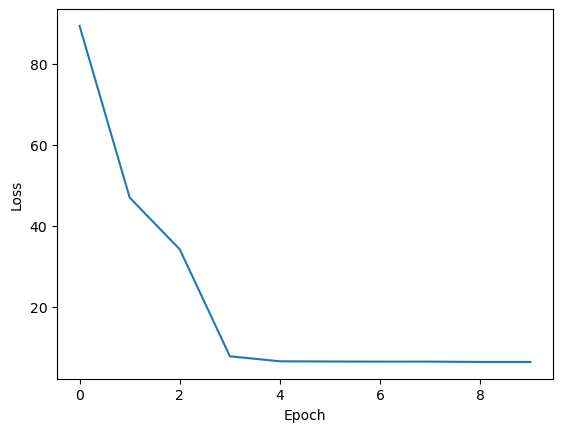

In [ ]:
plt.plot(cost, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

C:\Users\bartv\AppData\Local\Temp\ipykernel_7964\1559428499.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  spectrum_no_background[i] = spectrum - pred.cpu()


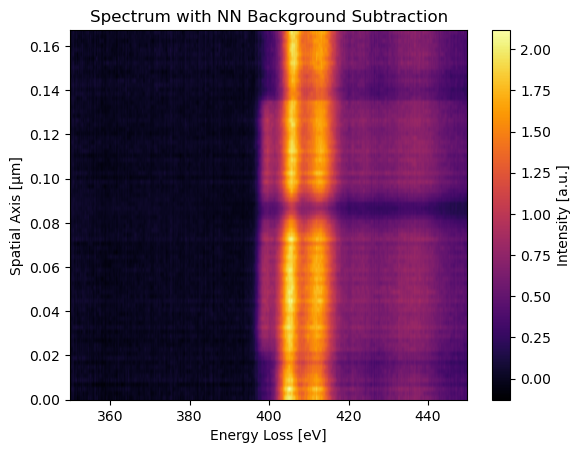

In [ ]:
spectrum_no_background = np.zeros_like(intensities)
for i, spectrum in enumerate(intensities):
    log_total = torch.log(spectrum.sum())

    X_single = torch.stack([
        energy_axis, 
        log_total.expand_as(energy_axis)
    ], dim=1)

    X_single = (X_single - X_mean) / X_std
    model.eval()
    with torch.no_grad():
        pred_log = model(X_single.to(device)).squeeze()

    pred_log = pred_log * y_std + y_mean
    pred = torch.exp(pred_log)
    spectrum_no_background[i] = spectrum - pred.cpu()

plt.imshow(spectrum_no_background, cmap='inferno', aspect='auto', extent=
        [energy_loss_axis_trimmed[0], energy_loss_axis_trimmed[-1], spatial_axis[0], spatial_axis[-1]])
plt.colorbar(label="Intensity [a.u.]")
plt.xlabel("Energy Loss [eV]")
plt.ylabel("Spatial Axis [μm]")
plt.title("Spectrum with NN Background Subtraction")
plt.show()